# Clustering MNIST


Exercice présenté <a href="http://www.exercices.openclassrooms.com/assessment/636" target="_blank">ici</a>

### Menu :

<ul>
    <li>Test du Kmeans</li>
        <ul>
            <li>Visualisation 3D</li>
            <li>Projection 2D</li>
        </ul>
    <li>Test du TSNE</li>
        <ul>
            <li>Visualisation 2D</li>
            <li>Visualisation 3D</li>
            <li>Visualisation 3D projetté en 2D (PCA)</li>
        </ul>
    <li>Spectral Embedding</li>
        <ul>
            <li>Visualisation 2D</li>
            <li>Visualisation 3D</li>
            <li>Visualisation 3D projetté en 2D (PCA)</li>
        </ul>
    <li>Evaluation</li>
    <ul>
        <li>Evaluation intrinsèque du t-SNE</li>
        <li>Evaluation "pratique" du Kmeans</li>
    </ul>
    <li>Conclusion</li>
</ul>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import scipy
import time

from sklearn.manifold import TSNE, SpectralEmbedding
from sklearn.datasets import fetch_mldata
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

start = time.time()

In [2]:
mnist = fetch_mldata('MNIST original', data_home="./")

In [3]:
X = mnist.data[::50, :]           # 70000 images, on en prend 1/50 soit 1400
y = mnist.target[::50]            # on en prend les labels

print(X.shape)
print(y.shape)

(1400, 784)
(1400,)


In [4]:
print(y)

[ 0.  0.  0. ...,  9.  9.  9.]


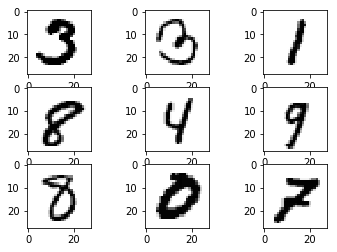

In [5]:
idx = np.random.randint(X.shape[0], size=9)
plt.figure(1)
pos = 331
for choice in X[idx,:]:
    mat = choice.reshape(28,28)
    plt.subplot(pos)
    plt.imshow(mat, cmap='binary')
    pos += 1
plt.show()

# Test du Kmeans

In [6]:
kmeans = KMeans(n_clusters=10, init="k-means++")

In [7]:
X_embedded = kmeans.fit_transform(X)

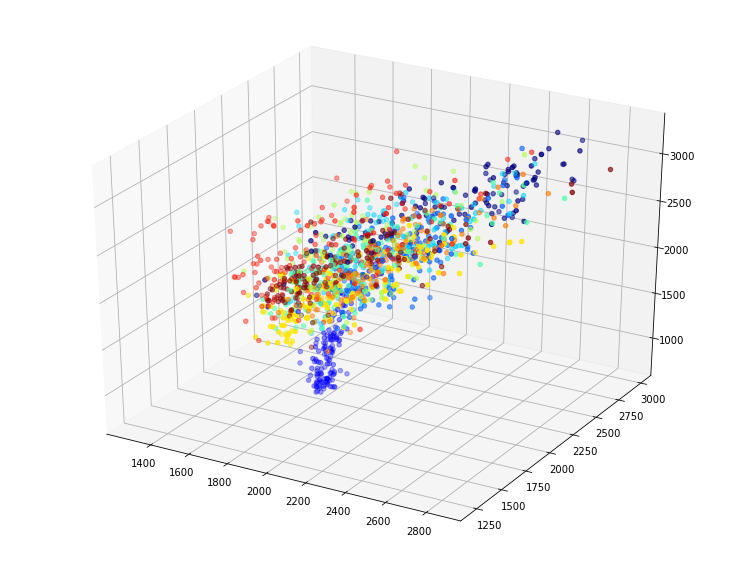

In [8]:
fig = plt.figure(figsize=(13,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], c=y, cmap="jet")
plt.show()

In [9]:
X_proj = PCA(n_components=2).fit_transform(X_embedded)

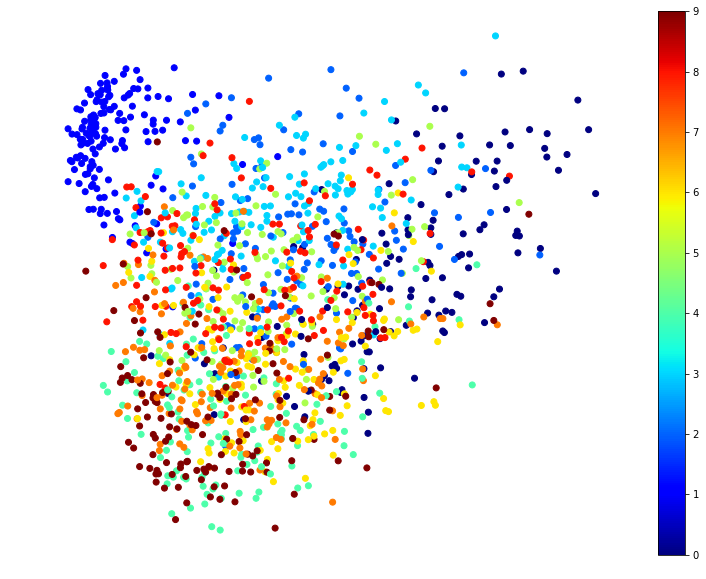

In [10]:
X_proj = PCA(n_components=2).fit_transform(X_embedded)
plt.figure(figsize=(13,10))
plt.scatter(X_proj[:, 0], X_proj[:, 1], c=y, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

On remarque sur la 3D un debut de partitionnement mais pas exceptionnel. Le 0 et 1 sortent un peu du lot mais le reste est très mélangé. On peut tester de la meme maniere le TSNE

# Test du TSNE

## 2D

In [11]:
tsne = TSNE(n_components=2)
X_embedded = tsne.fit_transform(X)

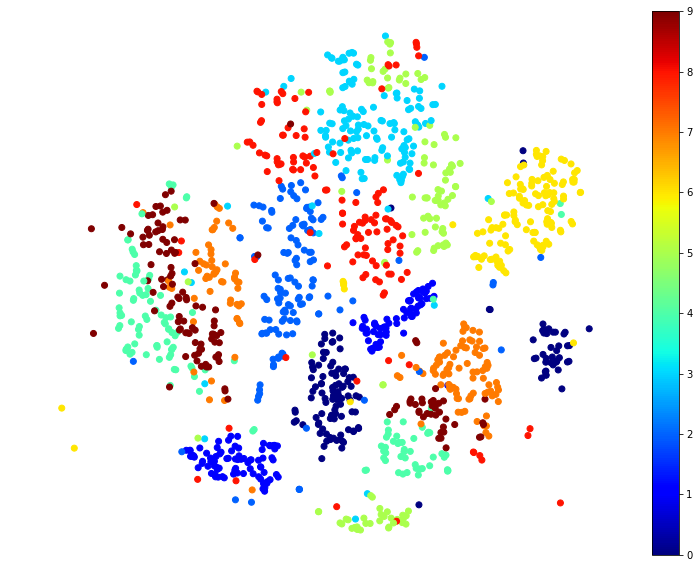

In [12]:
plt.figure(figsize=(13,10))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

## 3D

In [13]:
tsne = TSNE(n_components=3)
X_embedded = tsne.fit_transform(X)

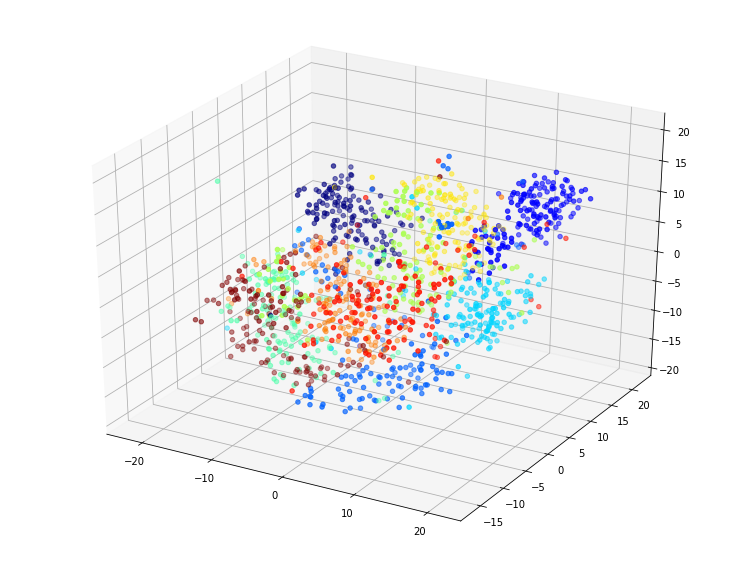

In [14]:
fig = plt.figure(figsize=(13,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], c=y, cmap="jet")
plt.show()

## 3D projected in 2D with PCA

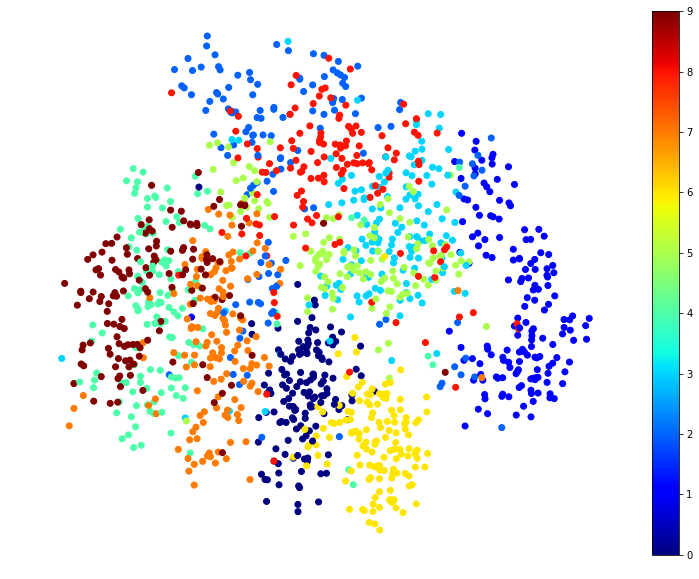

In [15]:
X_proj = PCA(n_components=2).fit_transform(X_embedded)
plt.figure(figsize=(13,10))
plt.scatter(X_proj[:, 0], X_proj[:, 1], c=y, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

Le TSNE en 3D et 2D proposent de beau partitionnement à premiere vue. Par contre, si on projette le 3D en 2D, le resultat est moins propre que le TSNE en 2D. C'est pour l'instant l'ousider ! On peut aussi tester le Spectral Embedding

# Test du Spectral Embedding

## 2D

In [16]:
spectral = SpectralEmbedding(n_components=2)
X_embedded = spectral.fit_transform(X)

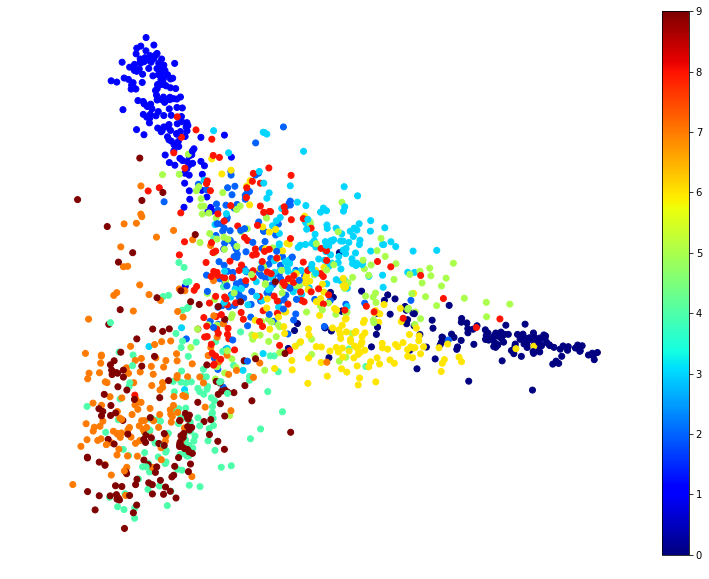

In [17]:
plt.figure(figsize=(13,10))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

## 3D

In [18]:
spectral = SpectralEmbedding(n_components=3)
X_embedded = spectral.fit_transform(X)

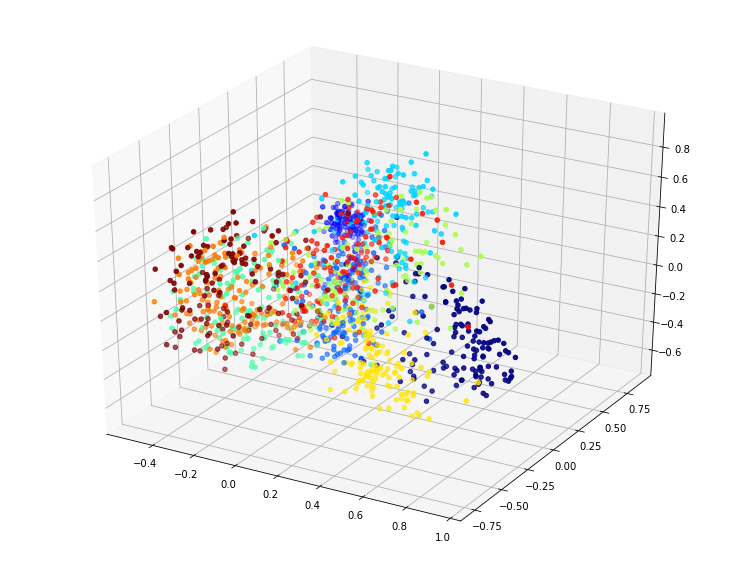

In [19]:
fig = plt.figure(figsize=(13,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], c=y, cmap="jet")
plt.show()

## 3D projected in 2D with PCA

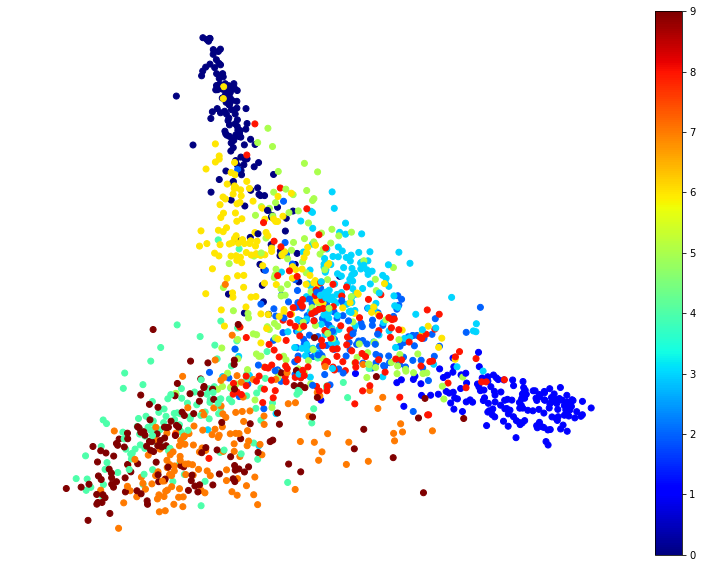

In [20]:
X_proj = PCA(n_components=2).fit_transform(X_embedded)
plt.figure(figsize=(13,10))
plt.scatter(X_proj[:, 0], X_proj[:, 1], c=y, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

Le Spectral Embedding n'est pas trop mal mais n'est pas exceptionnel pour autant. On remarque qu'il a bien séparé les groupes mais certains restent bien mélangés (que ce soit en 3D ou 2D). C'est le cas pour 7 (orange) et 9 (marron) par exemple. On va donc evaluer intrinsequement le TSNE qui est le meilleur

# Evaluation

## Evaluation Intrinsèque du t-SNE

On voit directement ci dessus que le t-SNE propose une meilleure decomposition que le K-means ou Spectral Embedding. On peut aussi évaluer son resultat. Intrinsèquement, on remarque bien les cluster qui sont bien séparés. Cependant, on peut aussi evaluer la précision des partitions en comparant le contenu des clusters avec les vrais labels.

In [21]:
def plot_digits(X, y, min_distance=0.05, images=None, figsize=(13, 10)):
    X_normalized = MinMaxScaler().fit_transform(X)
    neighbors = np.array([[10., 10.]])
    plt.figure(figsize=figsize)
    cmap = cm.get_cmap("jet")
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1], c=cmap(digit / 9))
    plt.axis("off")
    ax = plt.gcf().gca()  # get current axes in current figure
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(np.array(neighbors) - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(y[index] / 9), fontdict={"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"), image_coord)
                ax.add_artist(imagebox)

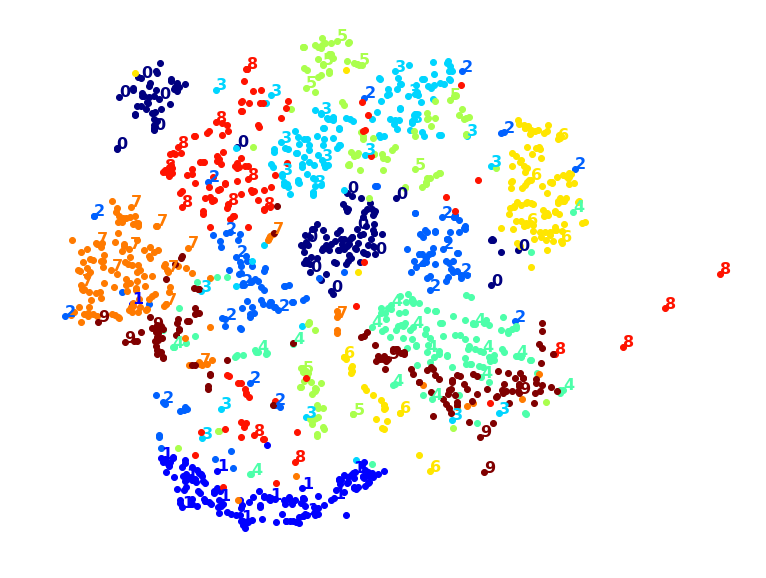

In [22]:
tsne = TSNE(n_components=2, random_state=42)              # recalcul car on a effacer precedemment les variables
X_embedded = tsne.fit_transform(X)

plot_digits(X_embedded, y)

On remarque que les partitions sont assez propre. Il y a cependant des clusters qui sont splittés en 2. Par exemple:
 - Le cluster de 5 qui est traversé par le cluster de 3 et de 0
 - Le cluster de 0 qui est traversé par le cluster de 8 (dans ce cas c'est assez logique car 0 et 8 sont assez proche graphiquement)

Logiquement, certains clusters sont proche car ils sont leur ecriture est proche comme :
 - Le cluster de 9 et 4 sont aussi très proche et presque mixés.
 - Le cluster de 7 et 1 ne sont pas très loin non plus
 - Le cluster de 0 et 8
 
On peut aussi tester de reduire légèrement le bruit en utilisant le PCA avant le T-SNE en gardant que les dimensions necessaire à une reconstruction avec 90% de loss

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 1400
[t-SNE] Computed conditional probabilities for sample 1400 / 1400
[t-SNE] Mean sigma: 473.867812
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.202990
[t-SNE] Error after 200 iterations: 1.202990


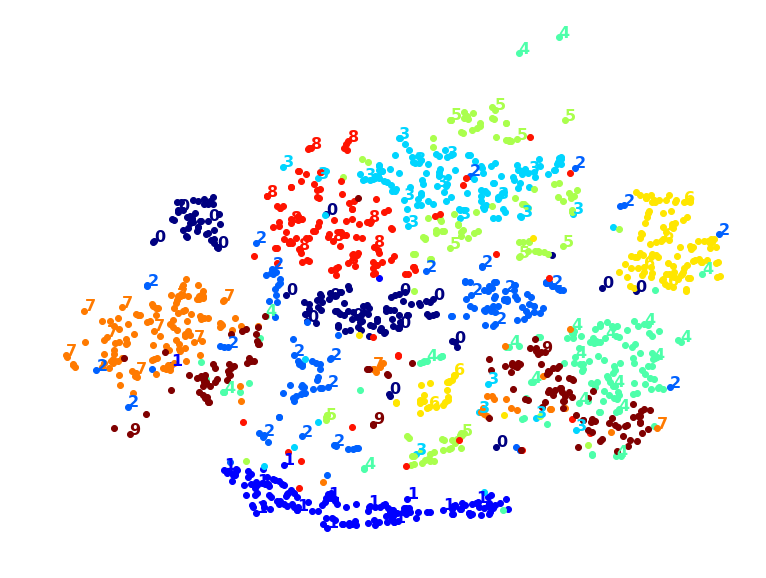

In [23]:
pca_tsne = Pipeline([
    ("pca", PCA(n_components=0.90, random_state=42)),
    ("tsne", TSNE(n_components=2, random_state=42, verbose=1, n_iter=300)),  # iter reduite a 300 pour accelerer un peu (1000 de base)
])
X_pca_tsne_reduced = pca_tsne.fit_transform(X)
plot_digits(X_pca_tsne_reduced, y)
plt.show()

Le clustering a l'air <b>légèrement</b> plus propre mais sans gain significatif, on peut partir dessus comme base de travail.

<b>J'ai essayé d'augmenter le nb de points pour voir si le partitionnement change mais cela fait crasher le notebook :(</b>

## Evaluation "pratique" du Kmeans

Le T-SNE ne possèdant pas de moyen d'être évalué par le calcul, on peut au moins pour des raisons d'apprentissage, repartir sur le Kmeans qui lui fourni des labels à ses clusters.

In [24]:
kmeans = KMeans(n_clusters=10, init="k-means++")
X_embedded = kmeans.fit_transform(X)

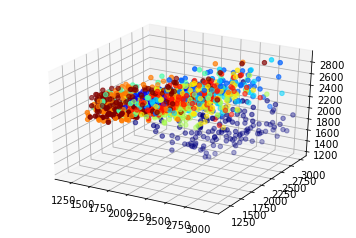

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_embedded[:, 0], X_embedded[:, 1], X_embedded[:, 2], c=y, cmap="jet")
plt.show()

In [26]:
y = y.astype("int")
print()
print(np.bincount(kmeans.labels_))
print(np.bincount(y))


[173 152 126 128 132 110 187 128 151 113]
[139 158 139 144 135 127 137 146 137 138]


In [27]:
for i in np.unique(kmeans.labels_):
    idx = np.where(kmeans.labels_ == i)
    temp = np.bincount(y[idx])
    label = np.argmax(temp)
    acc = np.max(temp)/np.sum(temp)
    phrase = "Le cluster {} correspond à l'ID {}. Le groupe labelise correctement {:.3f} % du cluster"
    print(phrase.format(i, label, acc*100))

Le cluster 0 correspond à l'ID 7. Le groupe labelise correctement 34.682 % du cluster
Le cluster 1 correspond à l'ID 7. Le groupe labelise correctement 44.079 % du cluster
Le cluster 2 correspond à l'ID 0. Le groupe labelise correctement 90.476 % du cluster
Le cluster 3 correspond à l'ID 4. Le groupe labelise correctement 35.938 % du cluster
Le cluster 4 correspond à l'ID 8. Le groupe labelise correctement 54.545 % du cluster
Le cluster 5 correspond à l'ID 6. Le groupe labelise correctement 91.818 % du cluster
Le cluster 6 correspond à l'ID 3. Le groupe labelise correctement 55.615 % du cluster
Le cluster 7 correspond à l'ID 2. Le groupe labelise correctement 58.594 % du cluster
Le cluster 8 correspond à l'ID 1. Le groupe labelise correctement 72.185 % du cluster
Le cluster 9 correspond à l'ID 1. Le groupe labelise correctement 42.478 % du cluster


Le kmeans a bien crée 10 cluster. Cependant beaucoup de cluster ne sont pas bons. En effet si on prend le cluster 1, 92.5% du cluster contient 0. Du coup on peut considérer que ce cluster est bon. Par contre si on prend le cluster 4, il contien en majorité 7 mais qu'a 32%... donc 68% des points de ce cluster font partie d'un autre groupe... On remarque meme que 2 clusters ont en majorité le groupe 7 (cluster 4 et 6) et aucun n'ont le 9 en majorité. Ce clustering n'est donc pas bon dans ce cas de figure.

# Conclusion

En conclusion, on remaque que le t-SNE a de loin le meilleur partitionnement. Malheuresement il n'y a pas de moyen simple de l'evaluer (comme on a fait sur le K-means) Cependant on est sur que son resultat aurait été meilleur que le kmeans car deja visuellement le partitionnement est bien meilleur. Cela explique sa popularité actuelle.

In [28]:
print("temps d'execution : {}".format(time.time()-start))

temps d'execution : 99.2254650592804
